**This example notebook provides code to visualize ReaLSAT dataset.**

In [4]:
import os
os.environ['USE_PYGEOS'] = '0'
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pathlib import Path
import pandas as pd
from datetime import datetime

### Functions

In [103]:
def read_data(file: Path) -> pd.DataFrame:
    """It loads the ReaLSAT monthly time series.
    
    Parameters:
    -----------
    file: Path
    
    """
    
    # loading timeseries data
    data = pd.read_csv(timeseries_path, header=None).transpose()
    data.columns = ['fill', 'update', 'area_ReaLSAT', 'area_GWS']
    dates = pd.date_range(datetime(1984, 1, 1), datetime(2020, 12, 31), freq='m')
    data.index = dates[:data.shape[0]]
    data.index.name = 'month'
    
    # convert area from pixel number to km²
    data[['area_ReaLSAT', 'area_GWS']] *= 0.0009 # multiplying by area of a single pixel

    return data

In [ ]:
# check if the average missing percentage before and after any given timestep is more than the threshold.
def prune_time_steps(data: pd.DataFrame, percent: int = 90, window_size: int = 3) -> pd.DataFrame:
    """It removes data from time steps surrounded by large amount of missing values.
    """
    
    assert 0 <= percent <= 100, '"percent" must be a value between 0 and 100.'
    assert 0 <= window_size, '"window_size" must be a positive integer.'
    
    Data = data.copy()
    
    # find timesteps surounded by missing values
    fill_ts = data.fill 
    T = Data.shape[0]
    prn_ts = pd.Series(0, index=data.index, dtype=bool) #np.zeros((T,)).astype(bool)
    for j in range(1, T - 1):
        cur_ts_before = fill_ts.iloc[max(0, j - window_size):j]
        cur_ts_after = fill_ts.iloc[j + 1:min(j + window_size + 1, T)]
        
        if cur_ts_before.mean() > percent or cur_ts_after.mean() > percent:
            prn_ts.iloc[j] = 1 #max([cur_sm, inp_ts[j]])
    if fill_ts.iloc[0] > percent:
        prn_ts.iloc[0] = 1
    if fill_ts.iloc[T - 1] > percent:
        prn_ts.iloc[T - 1] = 1
        
    # assign NaN values to the missing timesteps
    Data.loc[bad_ts, ['area_ReaLSAT', 'area_GWS']] = np.nan 
        
    return Data

### Configuration

In [7]:
base_folder = Path('Z:/nahaUsers/casadje/datasets/lakes/ReaLSAT')

In [21]:
#set up paths for data access
# base_folder = os.getcwd() + '/realsat_test3/' # change this to the absolute path of all the zip files
# if os.path.isdir(base_folder) == False:
#     os.mkdir(base_folder)

# path for extracting monthly shapes
monthly_shapes_folder = base_folder / 'monthly_shapes' 
if os.path.isdir(monthly_shapes_folder) == False:
    os.mkdir(monthly_shapes_folder)

# absolute path of the monthly timeseries zip file
monthly_timeseries_file = base_folder / 'monthly_timeseries.zip' 
# path for extracting monthly timeseries
monthly_timeseries_folder = base_folder / 'monthly_timeseries' 
if os.path.isdir(monthly_timeseries_folder)==False:
    os.mkdir(monthly_timeseries_folder)

# absolute path of the base shapefile
base_shapefile = base_folder / 'ReaLSAT-2-0/ReaLSAT.shp' 

In [ ]:
#download data
print('downloading base shapefile ...')
os.system('wget https://zenodo.org/record/5039223/files/ReaLSAT.zip -O ' + base_folder + 'ReaLSAT.zip')
print('downloading monthly timeseries zipfile ...')
os.system('wget https://zenodo.org/record/5039223/files/monthly_timeseries.zip -O ' + base_folder + 'monthly_timeseries.zip')
print('downloading monthly shapes zipfile')
for lon in range(-180,180,10):
    for lat in range(-90,90,10):
        cur_lon_str = str(lon)
        cur_lat_str = str(lat)
        cur_file_name = 'monthly_shapes_' + cur_lon_str + '_' + cur_lat_str + '.zip'
        r = requests.get('https://zenodo.org/record/5039223/files/' + cur_file_name , stream=True)
        if r.ok==False:
            continue
        print(lon,lat)
        os.system('wget https://zenodo.org/record/5039223/files/' + cur_file_name + ' -O ' + base_folder + cur_file_name)

### Base shapefile description

The base shapefile contains the reference shape of all the reservoirs. Please see below the description of different attributes -

**ID**: the unique ID for water body. ID values are used as names of shapefiles that contain monthly shapes.

**RESERVOIR**: categorizes water bodies into two sets - 1 represents reservoirs manually verified by visual validation, and 0 represents other water bodies. Note that the reservoir list is not exhaustive and water bodies with 0 value could be reservoirs. The reservoir subset was created using a machine learning methodology. Please refer to https://ai4earthscience.github.io/iclr-2020-workshop/papers/ai4earth28.pdf for more details.

**AREA**: number of LANDSAT 30-m pixels covered by the water body. This area was calculated by counting pixels in a water body that exists as water atleast 10 % of the time.

**Hylak_id**: The water body ID based on the HydroLAKES dataset. Water bodies that are not present in HdyroLAKEs but are available in ReaLSAT have ID as 0.

**Hylak_frc**: % overlap between ReaLSAT and HydroLAKES database.

**CONTINENT**: between 0 and 8 representing different continents -

0:Other 1:Asia 2:North America 3:Europe 4:Africa 5:South America 6:Oceania 7:Australia 8:Antarctica

**geometry**: reference shape of the reservoir

The remaining attributes listed below have been added to flag lakes where assumptions made by the ORBIT approach (used to create ReaLSAT dataset) might be violated -

**RIVR_SCORE**: morphological score used to exlude river segments.

**COMP_SCORE**: score to identify lakes that break to multiple components frequently.

**EPHM_SCORE**: score to identify lakes that are very transient.

**REL_DYN**: categorizes the water bodies into two sets - 1 represents water bodies for which changes made by the ORBIT algorithm (correcting erroneous labels in GSW dataset and filling missing labels) are more reliable. Please refer to the paper (http://umnlcc.cs.umn.edu/realsat/data/ReaLSAT.pdf) for more details.


In [25]:
# loading the base shapefile
rf = gpd.read_file(base_shapefile)
rf.set_index('ID', drop=True, inplace=True)
# print(rf)

print('Number of water bodies:\t{0}'.format(rf.shape[0]))
print('Number of reservoirs:\t{0}'.format(np.sum(rf['RESERVOIR'].values == 1)))

Number of water bodies:	681137
Number of reservoirs:	18698


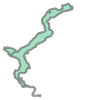

In [26]:
# display the reference shape of a water body
ID = 801275
temp = rf['geometry'][ID]
temp


### Monthly timeseries description

The csv contains monthly timeseries of the reservoir. Each csv contains 4 rows:

**Row 1**: fill percentage time series

**Row 2**: update percentage time series

**Row 3**: area time series from ReaLSAT

**Row 4**: area time series using GSW labels directly. Specifically, we simply counted number of water pixels in the monthly extent map as the area for that month. Note that the area variations are affected by missing data in GSW labels unlike ReaLSAT based timeseries (Row 3) which imputes missing data using a physics guided machine learning algorithm.

Note that the quality of label updates in ReaLSAT get impacted if there are lot of consecutive timesteps with large amounts of missing data (i.e. very high fill percentage value). Here, we provide a filter to remove timesteps with significant missing data in nearby months.


In [32]:
# extract timeseries data from the zipped file
temp_df = rf.loc[[ID], :]
cx = str(int(np.floor(temp_df.centroid.x.to_numpy()[0] / 10) * 10)) # bottom left longitude of the 10 deg x 10 deg cell
cy = str(int(np.floor(temp_df.centroid.y.to_numpy()[0] / 10) * 10)) # bottom left latitude of the 10 deg x 10 deg cell

#extracting only the csv file for the lake of interest
# os.system('unzip -o ' + str(monthly_timeseries_file) + ' monthly_timeseries_' + cx + '_' + cy + '/' + str(ID).zfill(6) + '.csv -d ' + str(monthly_timeseries_folder))

In [142]:
# loading timeseries data
timeseries_path = monthly_timeseries_folder / f'{cx}_{cy}' / f'ID_{ID:06}.csv'
data = read_data(timeseries_path)

In [147]:
# remove unreliable data
data_ = prune_time_steps(data, window_size=3, percent=90)

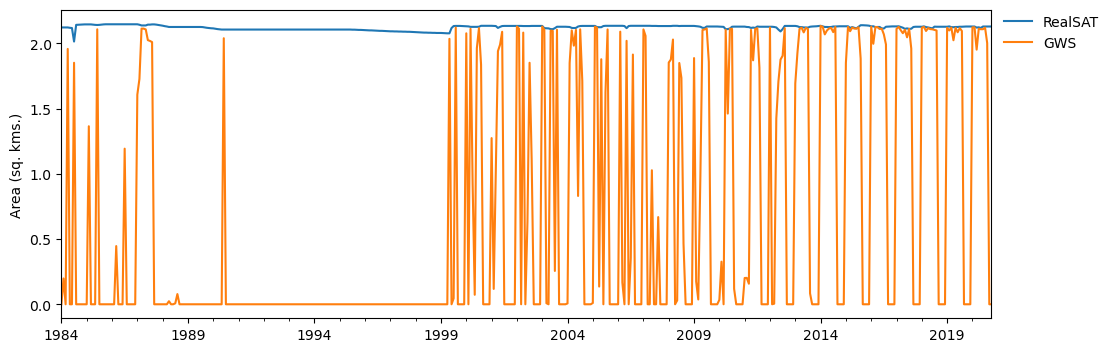

In [145]:
fig, ax = plt.subplots(figsize=(12, 4))
data.area_ReaLSAT.plot(ax=ax, label='RealSAT')
data.area_GWS.plot(ax=ax, label='GWS')
ax.set(xlabel=None, ylabel='Area (sq. kms.)')
fig.legend(bbox_to_anchor=[.8, .4, .2, .5], frameon=False);

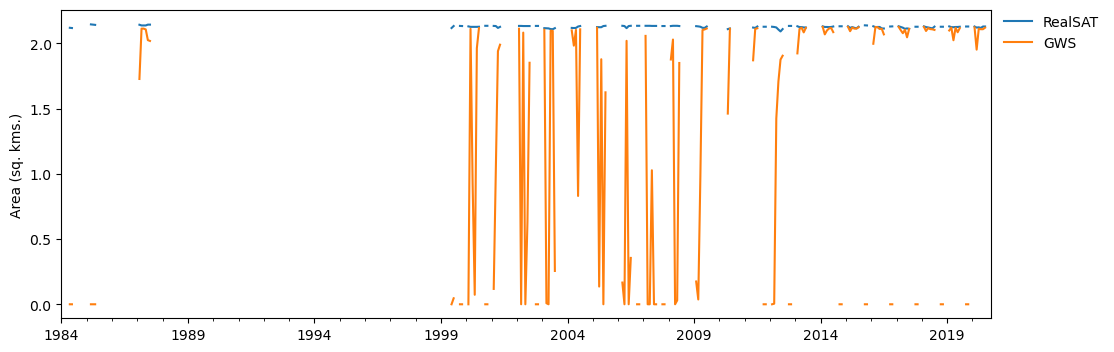

In [146]:
fig, ax = plt.subplots(figsize=(12, 4))
data_.area_ReaLSAT.plot(ax=ax, label='RealSAT')
data_.area_GWS.plot(ax=ax, label='GWS')
ax.set(xlabel=None, ylabel='Area (sq. kms.)')
fig.legend(bbox_to_anchor=[.8, .4, .2, .5], frameon=False);